In [1]:
# Mount Drive if needed
# from google.colab import drive
# drive.mount('/content/drive')


# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, export_text
import joblib
import os


# Display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

In [2]:
# Adjust path if using Drive
df = pd.read_csv('Iranian churn.csv')
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (3150, 14)


,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [5]:
# Basic info
df.info()
print(df.describe(include='all'))


# Check duplicates
dups = df.duplicated().sum()
print('Duplicates:', dups)
if dups>0:
    df = df.drop_duplicates()


# Missing values
print('Missing values per column:')
print(df.isnull().sum())


# Strategy: For numeric cols -> median imputation; categorical -> mode
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()


for c in num_cols:
    if df[c].isnull().sum()>0:
        df[c].fillna(df[c].median(), inplace=True)
for c in cat_cols:
    if df[c].isnull().sum()>0:
        df[c].fillna(df[c].mode()[0], inplace=True)


print('Missing after imputation:', df.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

In [8]:
target = [c for c in df.columns if 'churn' in c.lower()][0]
print("Target variable:", target)


Target variable: Churn


In [9]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

X = df.drop(columns=[target])
y = df[target]


In [10]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

X = df.drop(columns=[target])
y = df[target]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_pred_proba_lr = lr.predict_proba(X_test_scaled)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_lr))
print(classification_report(y_test, y_pred_lr))


Accuracy: 0.9032258064516129
ROC-AUC: 0.9324860351794628
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       601
           1       0.83      0.48      0.61       112

    accuracy                           0.90       713
   macro avg       0.87      0.73      0.78       713
weighted avg       0.90      0.90      0.89       713



In [13]:
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_dt))
print(export_text(dt, feature_names=list(X.columns)))


Accuracy: 0.9144460028050491
ROC-AUC: 0.9019417043023533
|--- Complains <= 0.50
|   |--- Status <= 1.50
|   |   |--- Subscription  Length <= 8.50
|   |   |   |--- Frequency of use <= 25.00
|   |   |   |   |--- class: 1
|   |   |   |--- Frequency of use >  25.00
|   |   |   |   |--- class: 0
|   |   |--- Subscription  Length >  8.50
|   |   |   |--- Seconds of Use <= 390.50
|   |   |   |   |--- class: 0
|   |   |   |--- Seconds of Use >  390.50
|   |   |   |   |--- class: 0
|   |--- Status >  1.50
|   |   |--- Subscription  Length <= 28.50
|   |   |   |--- Frequency of use <= 37.50
|   |   |   |   |--- class: 0
|   |   |   |--- Frequency of use >  37.50
|   |   |   |   |--- class: 1
|   |   |--- Subscription  Length >  28.50
|   |   |   |--- Distinct Called Numbers <= 3.50
|   |   |   |   |--- class: 1
|   |   |   |--- Distinct Called Numbers >  3.50
|   |   |   |   |--- class: 0
|--- Complains >  0.50
|   |--- Seconds of Use <= 5983.00
|   |   |--- Subscription  Length <= 42.50
|   |  

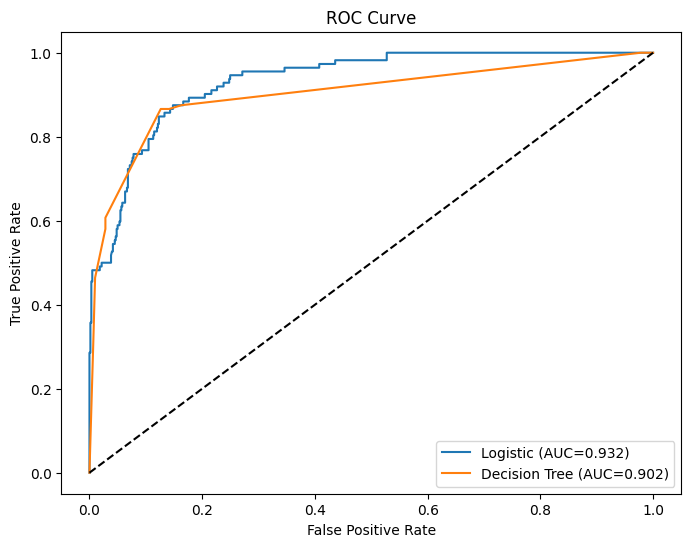

In [14]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic (AUC={roc_auc_score(y_test, y_pred_proba_lr):.3f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={roc_auc_score(y_test, y_pred_proba_dt):.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [15]:
joblib.dump(lr, 'logistic_model.joblib')
joblib.dump(dt, 'decision_tree_model.joblib')
print("Models saved successfully!")


Models saved successfully!


In [16]:
def lift_gain(y_true, y_prob, bins=10):
    df_lift = pd.DataFrame({'y': y_true, 'p': y_prob})
    df_lift['decile'] = pd.qcut(df_lift['p'].rank(method='first'), bins, labels=False)
    grouped = df_lift.groupby('decile').agg({'y':['sum','count']})
    grouped.columns = ['churns','total']
    grouped['response_rate'] = grouped['churns']/grouped['total']
    print(grouped)
    return grouped

lift_gain(y_test, y_pred_proba_lr)


        churns  total  response_rate
decile                              
0            0     72       0.000000
1            0     71       0.000000
2            0     71       0.000000
3            1     71       0.014085
4            2     72       0.027778
5            2     71       0.028169
6            7     71       0.098592
7           14     71       0.197183
8           30     71       0.422535
9           56     72       0.777778


,churns,total,response_rate
decile,,,
0,0,72,0.000000
1,0,71,0.000000
2,0,71,0.000000
3,1,71,0.014085
4,2,72,0.027778
5,2,71,0.028169
6,7,71,0.098592
7,14,71,0.197183
8,30,71,0.422535
